In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import xarray as xr
import xbudget
import xwmb
from CM4Xutils import *

Matplotlib is building the font cache; this may take a moment.


In [128]:
local_path_to_budgets_zarr = "../../../codedev/CM4Xutils/data/coarsened/CM4Xp125_budgets_sigma2_2000-2004.zarr"

In [129]:
ds = xr.open_zarr(local_path_to_budgets_zarr)
grid = ds_to_grid(ds.fillna(0.))

Inferring Z grid coordinate: density `sigma2`


In [84]:
grid._ds = grid._ds.assign_coords({
    "sigma0_l": [26., 27.2, 28.],
    "sigma0_i": [-100, 26.8528, 27.4976, 100]
})

In [116]:
grid._ds = grid._ds.assign_coords({
    "sigma0_l": [25., 26.7, 28.],
    "sigma0_i": [-100, 26.1, 27.2, 100]
})

In [130]:
snap = ds[["thetao_bounds", "so_bounds", "thkcello_bounds"]]
snap = snap.rename({
    **{"time_bounds":"time"},
    **{v:v.replace("_bounds", "") for v in snap.data_vars}
})
coords = {'Z': {'center': 'sigma2_l', 'outer': 'sigma2_i'}}
grid_snap = xgcm.Grid(snap, coords={}, metrics={}, boundary={"Z":"extend"}, autoparse_metadata=False)
wm_snap = xwmt.WaterMass(grid)
snap["sigma0"] = wm_snap.get_density("sigma0")

snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})

/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [118]:
thetao_surface = wmb.sel_outcrop_lev(wmb.grid._ds["thetao"]).compute()
so_surface = wmb.sel_outcrop_lev(wmb.grid._ds["so"]).compute()
sigma0_surface = wmb.sel_outcrop_lev(wmb.grid._ds["sigma0"]).compute()

/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/work/hfd/.con

In [203]:
k_outcrops = (wmb.grid._ds["thkcello"]==0).isel(exp=0, time=0).argmin("sigma2_l").compute()

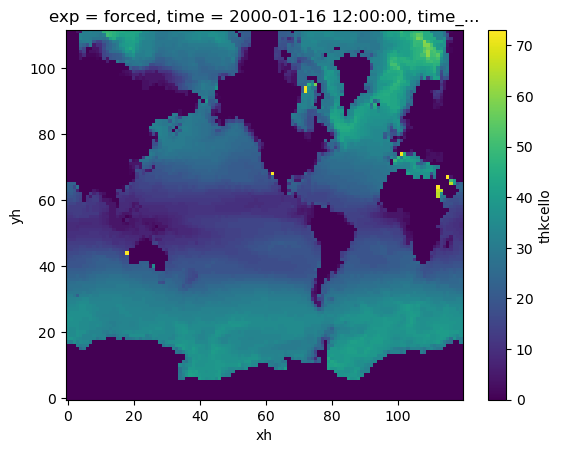

In [204]:
k_outcrops.plot()

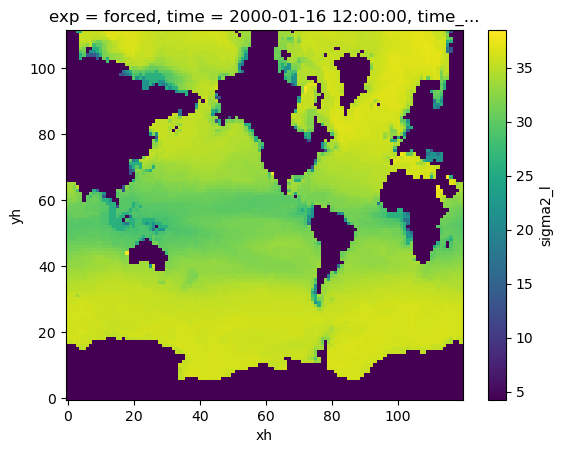

In [216]:
wmb.grid._ds["sigma2_l"].isel(sigma2_l = k_outcrops).plot()

In [183]:
sigma2_surface = wmb.sel_outcrop_lev(wmb.grid._ds["sigma2_l"]).compute()

ValueError: `da` must have the same dimensions as                `self.grid.Z_metrics[position].sel(**kwargs)`

Text(0.5, 1.0, 'sigma0 in the surface layer (OCIM levels)')

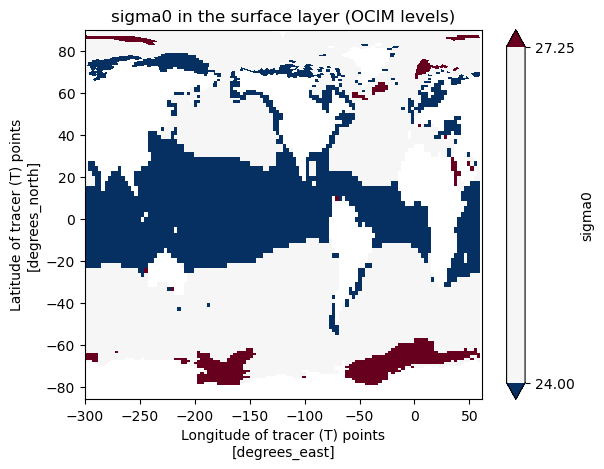

In [224]:
sigma0_surface.sel(exp="control").mean("time").plot(levels=[24, 27.25], x="geolon", y="geolat")
plt.title("sigma0 in the surface layer (OCIM levels)")

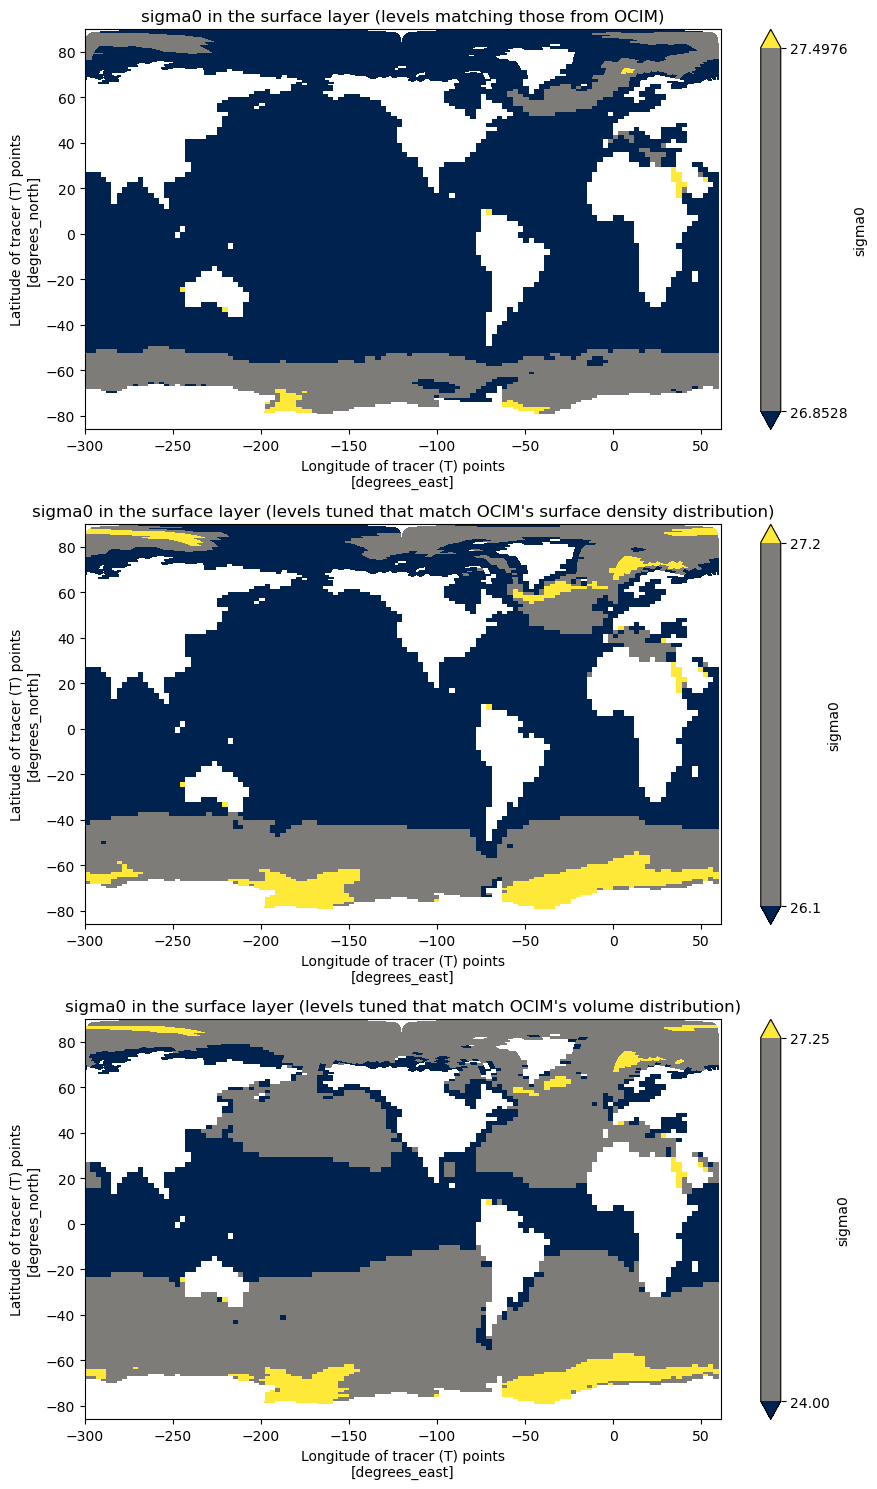

In [237]:
plt.figure(figsize=(9, 15))
plt.subplot(3,1,1)
sigma0_surface.sel(exp="control").mean("time").plot(levels=[26.8528, 27.4976], x="geolon", y="geolat", cmap="cividis")
plt.title("sigma0 in the surface layer (levels matching those from OCIM)")

plt.subplot(3,1,2)
sigma0_surface.sel(exp="control").mean("time").plot(levels=[26.1, 27.2], x="geolon", y="geolat", cmap="cividis")
plt.title("sigma0 in the surface layer (levels tuned that match OCIM's surface density distribution)")

plt.subplot(3,1,3)
sigma0_surface.sel(exp="control").mean("time").plot(levels=[24, 27.25], x="geolon", y="geolat", cmap="cividis")
plt.title("sigma0 in the surface layer (levels tuned that match OCIM's volume distribution)")
plt.tight_layout()
plt.savefig("surface_sigma0.png", dpi=200)

In [131]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
    xbudget.collect_budgets(grid, budgets_dict)
    
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        method="xgcm"
    )
    wmb.get_density("sigma0")
    wmb.grid._ds["sigma0_bounds"] = snap.sigma0_bounds
    #wmb.mass_budget("sigma0", greater_than=True, default_bins=False, integrate=True, along_section=False)
    wmb.mass_budget("sigma0", greater_than=True, default_bins=True, integrate=True, along_section=False)
    wmt = wmb.wmt

In [134]:
%%time
wmt_mean = (wmt.sel(exp="control").mean("time")/1035*1e-6)
wmt_mean.load()

CPU times: user 9min 58s, sys: 6min 9s, total: 16min 8s
Wall time: 1min 47s


<xarray.Dataset> Size: 1MB
Dimensions:                                         (sigma0_l_target: 500,
                                                     sigma0_i_target: 501,
                                                     time_bounds: 61, yh: 112,
                                                     xh: 120)
Coordinates: (12/13)
    exp                                             <U7 28B 'control'
  * sigma0_l_target                                 (sigma0_l_target) float64 4kB ...
  * sigma0_i_target                                 (sigma0_i_target) float64 4kB ...
  * time_bounds                                     (time_bounds) object 488B ...
    areacello                                       (yh, xh) float64 108kB 3....
    deptho                                          (yh, xh) float64 108kB 0....
    ...                                              ...
    geolon                                          (yh, xh) float64 108kB -2...
    lat                                             (yh, xh) float64 108kB -8...
    lon                                             (yh, xh) float64 108kB -2...
    wet                                             (yh, xh) float64 108kB 0....
  * xh                                              (xh) int64 960B 0 1 ... 119
  * yh                                              (yh) int64 896B 0 1 ... 111
Data variables: (12/39)
    surface_ocean_flux_advective_negative_lhs_heat  (sigma0_l_target) float64 4kB ...
    surface_ocean_flux_advective_negative_lhs_salt  (sigma0_l_target) float64 4kB ...
    advection_heat                                  (sigma0_l_target) float64 4kB ...
    advection_salt                                  (sigma0_l_target) float64 4kB ...
    surface_ocean_flux_advective_negative_rhs_heat  (sigma0_l_target) float64 4kB ...
    surface_ocean_flux_advective_negative_rhs_salt  (sigma0_l_target) float64 4kB ...
    ...                                              ...
    mass_tendency                                   (sigma0_l_target) float64 4kB ...
    dt                                              float64 8B 0.002539
    realized_transformation                         (sigma0_l_target) float64 4kB ...
    spurious_numerical_mixing                       (sigma0_l_target) float64 4kB ...
    advection_plus_BC                               (sigma0_l_target) float64 4kB ...
    diabatic_advection                              (sigma0_l_target) float64 4kB ...

Text(0.5, 0, 'Rate of transformation to lower densities [Sv]')

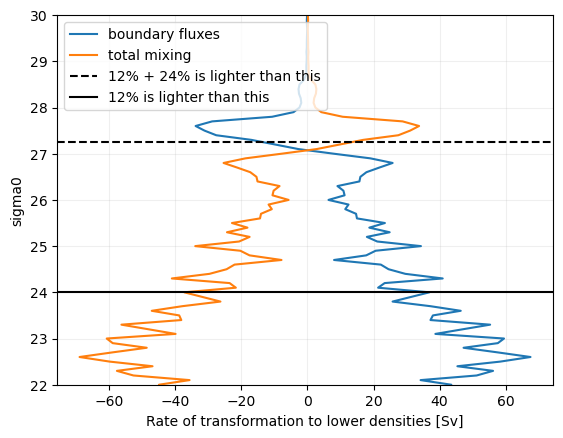

In [178]:
import matplotlib.pyplot as plt
(-wmt_mean.boundary_fluxes).plot(y="sigma0_l_target", label="boundary fluxes")
(-(wmt_mean.diffusion + wmt_mean.spurious_numerical_mixing)).plot(y="sigma0_l_target", label="total mixing")
plt.ylim(22, 30)

plt.axhline(27.25, color="k", linestyle="--", label="12% + 24% is lighter than this")
plt.axhline(24, color="k", linestyle="-", label="12% is lighter than this")
plt.grid(True, alpha=0.2)
plt.legend(loc="upper left")
plt.title("")
plt.ylabel("sigma0")
plt.xlabel("Rate of transformation to lower densities [Sv]")

In [166]:
total_mass = wmt_mean.layer_mass.sum("sigma0_l_target").values
upper_mass = wmt_mean.layer_mass.sel(sigma0_l_target=slice(-100, 24)).sum("sigma0_l_target").values
inter_mass = wmt_mean.layer_mass.sel(sigma0_l_target=slice(24, 27.25)).sum("sigma0_l_target").values

upper_mass/total_mass, inter_mass/total_mass

(0.12108478486325536, 0.24167855191501716)

In [151]:
wmt_mean.layer_mass / wmt_mean.layer_mass.sum()

<xarray.DataArray 'layer_mass' (sigma0_l_target: 500)> Size: 4kB
array([3.97727456e-06, 3.43107075e-08, 3.18269793e-08, 3.23445469e-08,
       3.49163968e-08, 3.63161457e-08, 3.67062126e-08, 3.69916390e-08,
       3.72963146e-08, 3.72780513e-08, 3.62201824e-08, 3.45852879e-08,
       3.35683871e-08, 3.13348775e-08, 2.87655645e-08, 2.62112333e-08,
       2.40335865e-08, 2.25152341e-08, 2.05544275e-08, 2.00946683e-08,
       1.91387064e-08, 1.78862718e-08, 1.68194646e-08, 1.60829090e-08,
       1.55914546e-08, 1.52266936e-08, 1.45846650e-08, 1.40333890e-08,
       1.32445792e-08, 1.27701307e-08, 1.24558153e-08, 1.22365666e-08,
       1.14432807e-08, 1.21559771e-08, 1.22146554e-08, 1.20203514e-08,
       1.20881012e-08, 1.20603714e-08, 1.24063542e-08, 1.24013263e-08,
       1.25103786e-08, 1.27988469e-08, 1.31830067e-08, 1.33551988e-08,
       1.32420304e-08, 1.40859930e-08, 1.37230348e-08, 1.46889908e-08,
       1.39423051e-08, 1.46991785e-08, 1.46796584e-08, 1.49201800e-08,
       1.49745896e-08, 1.56973553e-08, 1.75513646e-08, 1.81415917e-08,
       1.86888877e-08, 2.11775770e-08, 2.25579278e-08, 2.44296004e-08,
       3.05729008e-08, 3.17720329e-08, 3.44280975e-08, 4.39705440e-08,
       4.77399060e-08, 5.42234181e-08, 5.04121868e-08, 4.12709736e-08,
       4.08842596e-08, 6.95974756e-08, 4.84510330e-07, 7.37974527e-07,
       7.39731978e-07, 7.40988373e-07, 7.42891973e-07, 7.45851748e-07,
       7.56889775e-07, 7.53495923e-07, 7.62295642e-07, 7.76232085e-07,
...
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
Coordinates:
    exp              <U7 28B 'control'
  * sigma0_l_target  (sigma0_l_target) float64 4kB 0.0 0.1 0.2 ... 49.8 49.9

In [55]:
wmt_mean["boundary_fluxes"]

<xarray.DataArray 'boundary_fluxes' (sigma0_l_target: 3)> Size: 24B
array([-3.71081077,  7.11164601,  0.50120852])
Coordinates:
    exp              <U7 28B 'control'
  * sigma0_l_target  (sigma0_l_target) float64 24B 26.0 27.2 28.0

In [93]:
def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

(-50.0, 50.0)

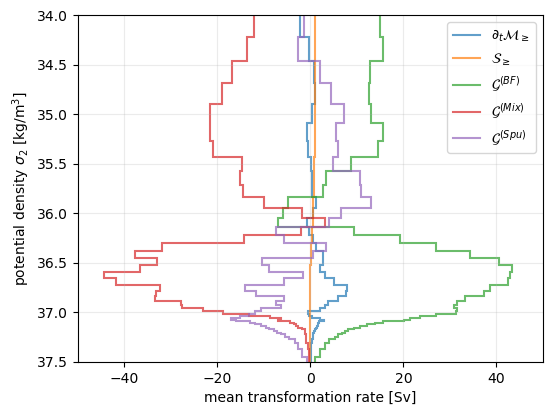

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

stairs(-wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}_{\geq}$",**kwargs)
stairs( wmt_mean, 'mass_source',               label=r"$\mathcal{S}_{\geq}$",            **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Spu)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.5, 34.);
plt.xlim(-50, 50)